In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
import time
import scipy as sp
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, DistilBertConfig
from transformers import AdamW, get_scheduler
from matplotlib import pyplot as plt
from datasets import load_dataset, Dataset, load_metric

from tqdm.auto import tqdm

In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


rd = pd.read_csv("/content/drive/MyDrive/complaints.csv").head(2000)
rde = rd[["Complaint ID", "Product", "Consumer complaint narrative"]]
rde2 = rde.rename(columns={"Product":"product_group",
                                                            'Consumer complaint narrative':'text',
                                                            "Complaint ID":"Complaint_ID"})
rde2.columns
rde3 = rde2.dropna(inplace=False)

rde3.loc[rde3['product_group'] == 'Credit reporting, credit repair services, or other personal consumer reports', 'product_group'] = 'Credit reporting'
rde3.loc[rde3['product_group'] == 'Credit card', 'product_group'] = 'Credit card or prepaid card'
rde3.loc[rde3['product_group'] == 'Prepaid card', 'product_group'] = 'Credit card or prepaid card'
rde3.loc[rde3['product_group'] == 'Payday loan', 'product_group'] = 'Payday loan, title loan, or personal loan'
rde3.loc[rde3['product_group'] == 'Virtual currency', 'product_group'] = 'Money transfer, virtual currency, or money service'
rde3.loc[rde3['product_group'] == 'Money transfers', 'product_group'] = 'Money transfer, virtual currency, or money service'
rde3 = rde3[rde3.product_group != 'Other financial service']

rde3['product_group'].value_counts()

rde3.head(10)
rde3.shape

'\nraw_data = pd.read_csv("/content/drive/MyDrive/complaints.csv").head(2000)\nraw_data_essentials = raw_data[["Complaint ID", "Product", "Consumer complaint narrative"]]\nraw_data_essentials_2 = raw_data_essentials.rename(columns={"Product":"product_group", \n                                                            \'Consumer complaint narrative\':\'text\', \n                                                            "Complaint ID":"Complaint_ID"})\nraw_data_essentials_2.columns\nraw_data_essentials_3 = raw_data_essentials_2.dropna(inplace=False)\n\nraw_data_essentials_3.loc[raw_data_essentials_3[\'product_group\'] == \'Credit reporting, credit repair services, or other personal consumer reports\', \'product_group\'] = \'Credit reporting\'\nraw_data_essentials_3.loc[raw_data_essentials_3[\'product_group\'] == \'Credit card\', \'product_group\'] = \'Credit card or prepaid card\'\nraw_data_essentials_3.loc[raw_data_essentials_3[\'product_group\'] == \'Prepaid card\', \'product_group

Columns (9,16) have mixed types.Specify dtype option on import or set low_memory=False.


Index(['Complaint_ID', 'product_group', 'text'], dtype='object')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Credit reporting                                      25
Debt collection                                        3
Checking or savings account                            3
Mortgage                                               3
Student loan                                           2
Credit card or prepaid card                            1
Vehicle loan or lease                                  1
Money transfer, virtual currency, or money service     1
Name: product_group, dtype: int64

,Complaint_ID,product_group,text
85,6192011,Credit reporting,Im resubmitting a complaint to you today to in...
90,6192034,Credit reporting,On XX/XX/2022. I checked my credit report and ...
542,6363495,Credit reporting,I XXXX XXXX XXXX am filing this complaint on b...
622,6522205,Credit reporting,"In accordance with the "" Fair Credit Reporting..."
666,6522688,Credit reporting,A relative in XXXX used my social security num...
673,6492545,Debt collection,"Cascade Capital Funding , LLC incorrectly repo..."
681,6544514,Credit reporting,This is my 5th endeavor to tell you that I am ...
700,6523010,Credit reporting,You recently stated you did an investigation o...
758,6498901,Checking or savings account,As a customer of Regions Bank I have been disc...
807,6492035,Credit card or prepaid card,I am submitting this complaint because I had X...


(39, 3)

In [ ]:

for i in range(0, 10):
    print(rde3['text'].iloc[i])

"\nfor i in range(0, 10):\n    print(raw_data_essentials_3['text'].iloc[i])\n"

Im resubmitting a complaint to you today to inform you I was the victim of identity theft. I researched how to remove the fraudulent items in my report and found that I need to visit FEDERAL TRADE COMMISSION or https : //www.ftc.gov to file a report Per FCRA section 605b Credit Reporting Agencies are required to remove any item listed on an id theft report. Please find the ATTACHED documents to assist in blocking the erroneous information which is being posted to my report. 

Here is the list of items that do not belong to me or were opened without my permission. 

XXXXXXXX XXXX XXXX XXXX XXXXXXXX, GA XXXX ; XXXX XXXX XXXX XXXX XXXX XXXX GA XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX GA XXXX XXXX XXXX XXXX XXXX XXXX, GA XXXX XXXX XXXX XXXX XXXX XXXXXXXX* Balance : {$0.00} XXXX XXXXXXXX XXXX XXXX XXXXXXXX Balance : {$0.00} ; XXXXXXXX XXXX XXXX XXXXXX/XX/XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXXXX/XX/XXXX XXXX XXXX XX/XX/XXXX ; XXXX XX/XX/XXXX ; XXXX XX/XX/XXXX XXXX XXXX XXXX XX

In [ ]:
def remove_x(input_string):
    string = re.sub(r'[X]+\/[X]+\/\d+|[X]+', "", input_string)
    return string



In [ ]:
def clean_text(input_string):
    string = re.sub(r'(?<!\d)[.,;:%$[]](?!\d)',"", input_string)
    string_2 = string.replace('\n', '')
    return string_2



In [ ]:
def complaint_length_histogram(clean_data, field):
    clean_data[field].hist(bins=30, figsize=(10,10))
    plt.xlabel("Number of Words Per Complaint", fontsize=12)
    plt.ylabel("Frequency",fontsize=12)
    return

In [ ]:

clean_data = rde3.copy(deep=True)
clean_data['text'] = rde3['text'].apply(remove_x)
clean_data


"\nclean_data = raw_data_essentials_3.copy(deep=True)\nclean_data['text'] = raw_data_essentials_3['text'].apply(remove_x)\nclean_data\n"

,Complaint_ID,product_group,text
85,6192011,Credit reporting,Im resubmitting a complaint to you today to in...
90,6192034,Credit reporting,On . I checked my credit report and I noticed ...
542,6363495,Credit reporting,I am filing this complaint on behalf of mys...
622,6522205,Credit reporting,"In accordance with the "" Fair Credit Reporting..."
666,6522688,Credit reporting,A relative in used my social security number ...
673,6492545,Debt collection,"Cascade Capital Funding , LLC incorrectly repo..."
681,6544514,Credit reporting,This is my 5th endeavor to tell you that I am ...
700,6523010,Credit reporting,You recently stated you did an investigation o...
758,6498901,Checking or savings account,As a customer of Regions Bank I have been disc...
807,6492035,Credit card or prepaid card,I am submitting this complaint because I had ...


In [ ]:
clean_data['text'] = clean_data['text'].apply(clean_text)
clean_data

,Complaint_ID,product_group,text
85,6192011,Credit reporting,Im resubmitting a complaint to you today to in...
90,6192034,Credit reporting,On . I checked my credit report and I noticed ...
542,6363495,Credit reporting,I am filing this complaint on behalf of mys...
622,6522205,Credit reporting,"In accordance with the "" Fair Credit Reporting..."
666,6522688,Credit reporting,A relative in used my social security number ...
673,6492545,Debt collection,"Cascade Capital Funding , LLC incorrectly repo..."
681,6544514,Credit reporting,This is my 5th endeavor to tell you that I am ...
700,6523010,Credit reporting,You recently stated you did an investigation o...
758,6498901,Checking or savings account,As a customer of Regions Bank I have been disc...
807,6492035,Credit card or prepaid card,I am submitting this complaint because I had ...


In [ ]:
clean_data['text_count'] = clean_data['text'].str.split().str.len()
clean_data


,Complaint_ID,product_group,text,text_count
85,6192011,Credit reporting,Im resubmitting a complaint to you today to in...,171
90,6192034,Credit reporting,On . I checked my credit report and I noticed ...,73
542,6363495,Credit reporting,I am filing this complaint on behalf of mys...,91
622,6522205,Credit reporting,"In accordance with the "" Fair Credit Reporting...",372
666,6522688,Credit reporting,A relative in used my social security number ...,92
673,6492545,Debt collection,"Cascade Capital Funding , LLC incorrectly repo...",208
681,6544514,Credit reporting,This is my 5th endeavor to tell you that I am ...,100
700,6523010,Credit reporting,You recently stated you did an investigation o...,409
758,6498901,Checking or savings account,As a customer of Regions Bank I have been disc...,134
807,6492035,Credit card or prepaid card,I am submitting this complaint because I had ...,212


In [ ]:
# Keep only text that is greater than 15 - 1000 words max, to filter out excessively long complaints
clean_data = clean_data[(clean_data['text_count'] >= 15) & (clean_data['text_count'] <= 1000)]
clean_data.head(10)

,Complaint_ID,product_group,text,text_count
85,6192011,Credit reporting,Im resubmitting a complaint to you today to in...,171
90,6192034,Credit reporting,On . I checked my credit report and I noticed ...,73
542,6363495,Credit reporting,I am filing this complaint on behalf of mys...,91
622,6522205,Credit reporting,"In accordance with the "" Fair Credit Reporting...",372
666,6522688,Credit reporting,A relative in used my social security number ...,92
673,6492545,Debt collection,"Cascade Capital Funding , LLC incorrectly repo...",208
681,6544514,Credit reporting,This is my 5th endeavor to tell you that I am ...,100
700,6523010,Credit reporting,You recently stated you did an investigation o...,409
758,6498901,Checking or savings account,As a customer of Regions Bank I have been disc...,134
807,6492035,Credit card or prepaid card,I am submitting this complaint because I had ...,212


<Figure size 720x720 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='product_group'>

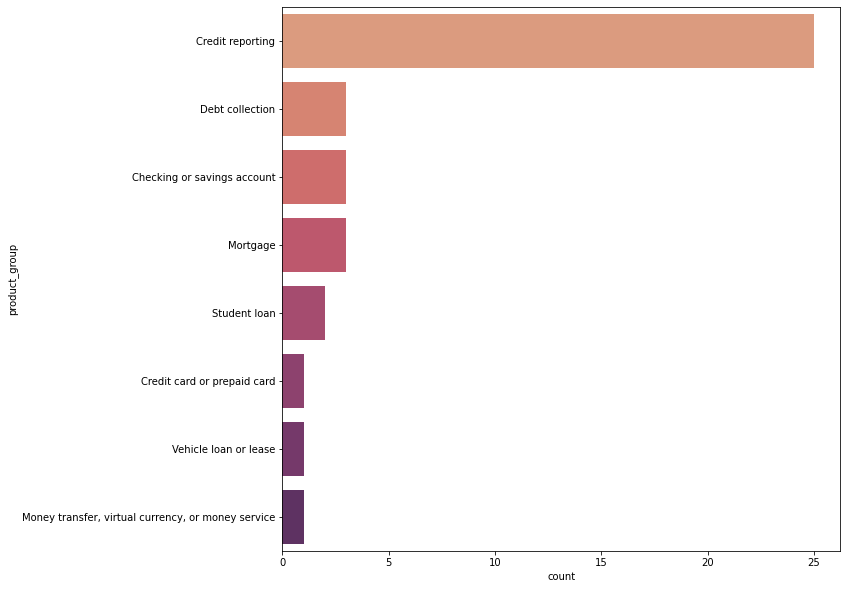

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='product_group', data = clean_data,order = clean_data['product_group'].value_counts().index,palette="flare")
plt.show()

<AxesSubplot:>

count     39.000000
mean     161.974359
std      150.485091
min       22.000000
25%       76.500000
50%      115.000000
75%      183.000000
max      827.000000
Name: text_count, dtype: float64

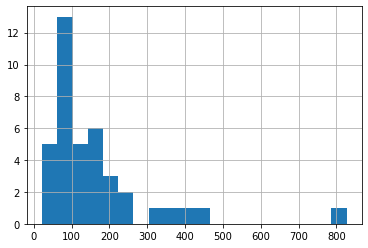

In [ ]:
clean_data['text_count'].hist(bins=20)
clean_data['text_count'].describe()

In [ ]:
le = LabelEncoder()
text_labels = le.fit_transform(clean_data['product_group'])
text_labels[0:20]
clean_data['product_group'] = le.fit_transform(clean_data['product_group'])
clean_data = pd.DataFrame(clean_data.loc[:, ['product_group', 'text']])
clean_data

array([2, 2, 2, 2, 2, 3, 2, 2, 0, 1, 6, 2, 0, 2, 5, 2, 7, 2, 2, 2])

,product_group,text
85,2,Im resubmitting a complaint to you today to in...
90,2,On . I checked my credit report and I noticed ...
542,2,I am filing this complaint on behalf of mys...
622,2,"In accordance with the "" Fair Credit Reporting..."
666,2,A relative in used my social security number ...
673,3,"Cascade Capital Funding , LLC incorrectly repo..."
681,2,This is my 5th endeavor to tell you that I am ...
700,2,You recently stated you did an investigation o...
758,0,As a customer of Regions Bank I have been disc...
807,1,I am submitting this complaint because I had ...


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


00              1.092992
00 11000        0.094516
00 according    0.076407
00 balance      0.256070
00 constant     0.094516
                  ...   
yes             0.361006
yes accounts    0.353229
yes admin       0.048547
youre           0.049945
youre using     0.049945
Length: 3287, dtype: float64

Time Taken for Text List of Length  39 : 1.1


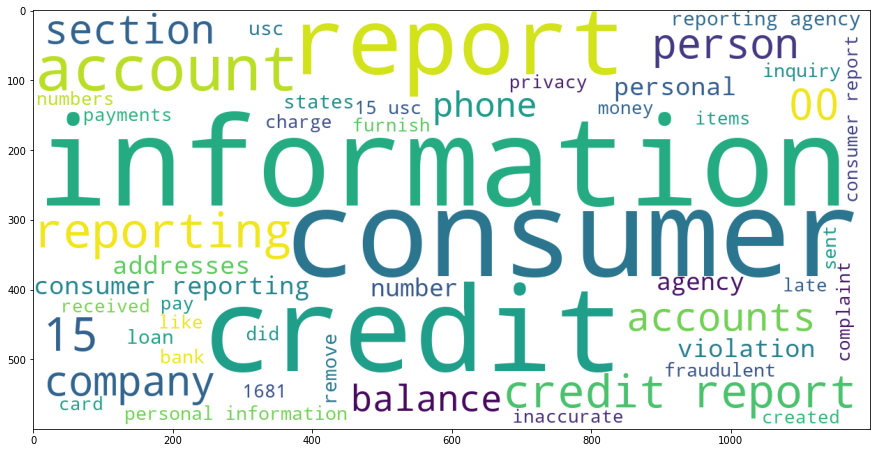

In [ ]:
from wordcloud import WordCloud
texts = clean_data['text'].tolist()[0:1000]
def get_word_cloud(corpus, ngrams=(1,2)):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngrams)
    vecs = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    dense = vecs.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    display(df.T.sum(axis=1))
    Cloud = WordCloud(background_color="white", max_words=50,
                      width=1200, height=600).generate_from_frequencies(df.T.sum(axis=1))
    plt.figure(figsize=(15,10))
    display(plt.imshow(Cloud))
    return df

t0 = time.time()
tfidf_1 = get_word_cloud(texts)
print("Time Taken for Text List of Length ", len(texts), ":", round(time.time() - t0, 2))

In [ ]:
tfidf_1_list = pd.DataFrame(tfidf_1.T.sum(axis=1), columns=['TFIDF_Score']).sort_values(by=['TFIDF_Score'], ascending=False)
tfidf_1_list.head(10)
tfidf_1_list.reset_index(level=0, inplace=True)
freq_word_list = tfidf_1_list['index'].tolist()[0:10]

,TFIDF_Score
information,2.261223
consumer,2.214749
credit,2.052363
report,1.926034
account,1.556171
reporting,1.427847
15,1.336924
credit report,1.240627
00,1.092992
company,1.015968


In [ ]:
clean_data
clean_data.columns

,product_group,text
85,2,Im resubmitting a complaint to you today to in...
90,2,On . I checked my credit report and I noticed ...
542,2,I am filing this complaint on behalf of mys...
622,2,"In accordance with the "" Fair Credit Reporting..."
666,2,A relative in used my social security number ...
673,3,"Cascade Capital Funding , LLC incorrectly repo..."
681,2,This is my 5th endeavor to tell you that I am ...
700,2,You recently stated you did an investigation o...
758,0,As a customer of Regions Bank I have been disc...
807,1,I am submitting this complaint because I had ...


Index(['product_group', 'text'], dtype='object')

In [ ]:
comp_dataset = Dataset.from_pandas(clean_data).train_test_split(test_size=0.2)
comp_dataset

DatasetDict({
    train: Dataset({
        features: ['product_group', 'text', '__index_level_0__'],
        num_rows: 31
    })
    test: Dataset({
        features: ['product_group', 'text', '__index_level_0__'],
        num_rows: 8
    })
})

In [ ]:

## number of unique cats
num_cats = len(clean_data['product_group'].unique())
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = comp_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text", '__index_level_0__'])
tokenized_datasets = tokenized_datasets.rename_column("product_group", "labels")
tokenized_datasets.set_format("torch")

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)
myconfig = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=num_cats)
model = DistilBertForSequenceClassification(config=myconfig)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
## print(num_training_steps)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

metric = load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

  0%|          | 0/12 [00:00<?, ?it/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

True

True

True

True

True

True

True

True

True

True

True

True

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

{'accuracy': 0.5}